# Fractional VQE Portfolio Optimization

This notebook solves a **long-only fractional portfolio allocation** using a **Variational Quantum Eigensolver (VQE)**-style hybrid loop in PennyLane.

## Model

We target the mean–variance objective

\[
\min_{w \in \Delta}\; -\mu^\top w + \lambda\, w^\top \Sigma w,
\]

where:
- \(\mu\) is the expected return vector,
- \(\Sigma\) is the covariance matrix,
- \(\lambda \ge 0\) controls risk aversion,
- \(\Delta = \{ w \in \mathbb{R}^n: w_i \ge 0,\ \sum_i w_i = 1\}\) is the probability simplex.

## Parameterization (best practice)

We parameterize \(w(\theta)\) to lie on the simplex **by construction**:

1. Prepare an \(n\)-qubit circuit with tunable angles \(\theta\).
2. Read out \(z_i(\theta)=\langle Z_i\rangle\).
3. Map to nonnegative scores \(s_i(\theta)=\frac{1-z_i(\theta)}{2}\in[0,1]\).
4. Normalize to weights \(w_i(\theta)=\frac{s_i(\theta)}{\sum_j s_j(\theta)}\).

This avoids penalty tuning and ensures outputs are always valid allocations.

## Outputs

- Convergence (cost vs iteration)
- Allocation (bar + pie)
- \(\lambda\)-sweep allocation and efficient frontier \((\sigma, R)\), where
  \(\sigma=\sqrt{w^\top\Sigma w}\), \(R=\mu^\top w\).

## Notes

- The baseline ansatz is a single \(R_Y\) layer (independent per asset).
- You can increase expressivity by adding entanglers and depth.
- For \(\lambda\)-sweeps, warm-starting from the previous solution improves smoothness.

In [1]:
import os
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl

# Reproducibility
SEED = 0
np.random.seed(SEED)

# Output dir (store alongside notebook working directory)
os.makedirs("images", exist_ok=True)

In [2]:
# Problem setup (toy example)
mu = np.array([0.10, 0.20, 0.15, 0.12], requires_grad=False)  # expected returns
Sigma = np.array(
    [
        [0.005, -0.010, 0.004, -0.002],
        [-0.010, 0.040, -0.002, 0.004],
        [0.004, -0.002, 0.023, 0.002],
        [-0.002, 0.004, 0.002, 0.018],
    ],
    requires_grad=False,
)

# Defensive symmetrization (empirical covariances can be slightly asymmetric)
Sigma = 0.5 * (Sigma + Sigma.T)

n_assets = len(mu)

# Risk aversion
lam = 5.0

In [3]:
# Configuration (kept explicit for future packaging)
@dataclass(frozen=True)
class VQEConfig:
    steps: int = 75
    stepsize: float = 0.3
    log_every: int = 5
    shots: int | None = None  # None -> exact expectations (statevector)


cfg = VQEConfig()

In [4]:
# Device and ansatz (baseline: 1-layer RY)
dev = qml.device("default.qubit", wires=n_assets, shots=cfg.shots)


def ansatz(thetas: np.ndarray) -> None:
    """Baseline ansatz: single RY layer (independent per asset)."""
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)


@qml.qnode(dev, interface="autograd")
def expvals_z(thetas: np.ndarray):
    ansatz(thetas)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]


def angles_to_weights(thetas: np.ndarray) -> np.ndarray:
    """
    Map circuit expectations to valid simplex weights.

    z_i = <Z_i>
    s_i = (1 - z_i)/2 in [0,1]
    w_i = s_i / sum_j s_j
    """
    z = qml.math.stack(expvals_z(thetas))
    s = (1.0 - z) * 0.5
    s_sum = qml.math.sum(s)
    w = s / (s_sum + 1e-12)
    return w


def portfolio_return(w):
    return qml.math.dot(mu, w)


def portfolio_variance(w):
    return qml.math.dot(w, qml.math.dot(Sigma, w))


def objective(thetas: np.ndarray):
    w = angles_to_weights(thetas)
    ret = qml.math.dot(mu, w)
    risk = qml.math.dot(w, qml.math.dot(Sigma, w))
    return -(ret) + lam * risk


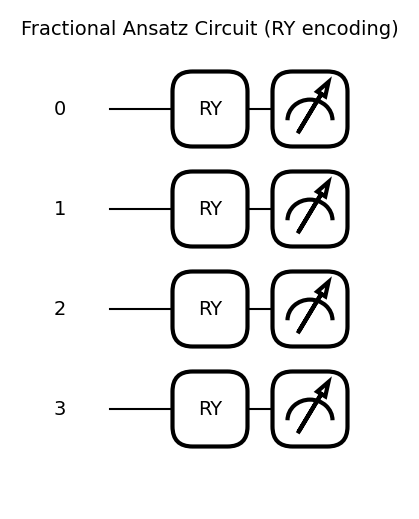

In [5]:
# Draw the circuit (for illustration)
sample_thetas = np.linspace(0, np.pi, n_assets)
fig, ax = draw_mpl(expvals_z)(sample_thetas)
fig.suptitle("Fractional Ansatz Circuit (RY encoding)", fontsize=14)
plt.savefig("images/Fractional_VQE_Circuit.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# Optimize
thetas = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=cfg.stepsize)

history_steps = []
history_cost = []

for t in range(cfg.steps):
    thetas, cost = opt.step_and_cost(objective, thetas)

    if (t + 1) % cfg.log_every == 0:
        w = angles_to_weights(thetas)
        history_steps.append(t + 1)
        history_cost.append(float(cost))
        print(
            f"step {t+1:03d}  cost={float(cost):.6f}  sum(w)={float(np.sum(w)):.6f}"
        )

step 005  cost=-0.122992  sum(w)=1.000000
step 010  cost=-0.124693  sum(w)=1.000000
step 015  cost=-0.124709  sum(w)=1.000000
step 020  cost=-0.124698  sum(w)=1.000000
step 025  cost=-0.124784  sum(w)=1.000000
step 030  cost=-0.124766  sum(w)=1.000000
step 035  cost=-0.124786  sum(w)=1.000000
step 040  cost=-0.124824  sum(w)=1.000000
step 045  cost=-0.124890  sum(w)=1.000000
step 050  cost=-0.124871  sum(w)=1.000000
step 055  cost=-0.124897  sum(w)=1.000000
step 060  cost=-0.124888  sum(w)=1.000000
step 065  cost=-0.124896  sum(w)=1.000000
step 070  cost=-0.124894  sum(w)=1.000000
step 075  cost=-0.124897  sum(w)=1.000000


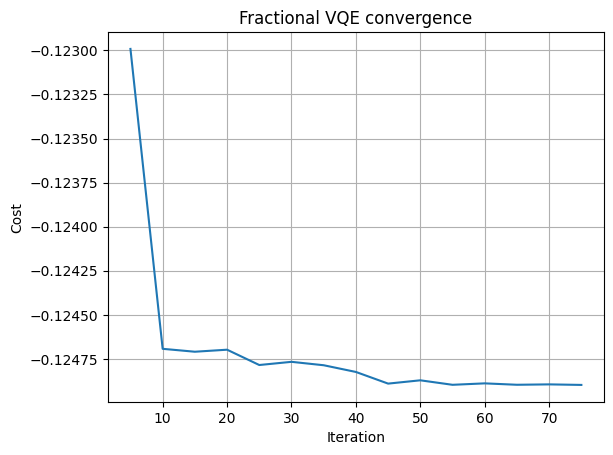

In [7]:
# Convergence plot
plt.figure()
plt.plot(history_steps, history_cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Fractional VQE convergence")
plt.grid(True)
plt.savefig("images/Fractional_VQE_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# Results
w_opt = angles_to_weights(thetas)
w_opt = w_opt / (np.sum(w_opt) + 1e-12)  # redundant but harmless; keeps reporting robust

print("\nOptimized allocation")
for i, w in enumerate(w_opt):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")

print(f"\nPortfolio return: {float(portfolio_return(w_opt)):.6f}")
print(f"Portfolio risk  : {float(np.sqrt(portfolio_variance(w_opt))):.6f}")


Optimized allocation
Asset 1: 48.19%
Asset 2: 35.64%
Asset 3: 13.06%
Asset 4: 3.11%

Portfolio return: 0.142792
Portfolio risk  : 0.059825


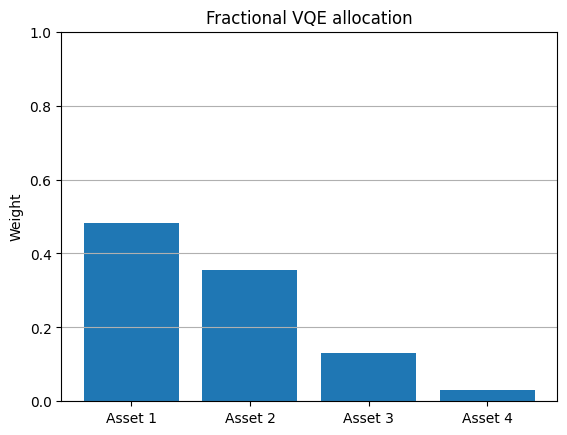

In [9]:
# Bar chart
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n_assets)], w_opt)
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Fractional VQE allocation")
plt.grid(axis="y")
plt.savefig("images/Fractional_VQE_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

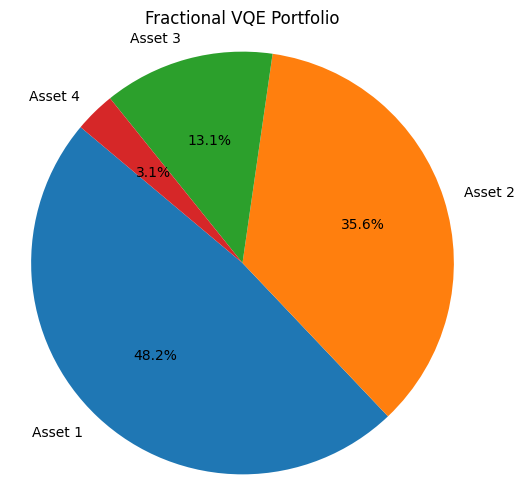

In [10]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    w_opt,
    labels=[f"Asset {i+1}" for i in range(n_assets)],
    autopct="%1.1f%%",
    startangle=140,
)
plt.title("Fractional VQE Portfolio")
plt.axis("equal")
plt.savefig("images/Fractional_VQE_Pie.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# λ sweep (warm-started)
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)

allocs = []
theta_ws = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)

sweep_steps = 60
sweep_stepsize = 0.2

for lam_val in lambdas:
    # update global lambda used by objective
    lam = float(lam_val)

    opt = qml.AdamOptimizer(stepsize=sweep_stepsize)
    for _ in range(sweep_steps):
        theta_ws, _ = opt.step_and_cost(objective, theta_ws)

    w = angles_to_weights(theta_ws)
    w = w / (np.sum(w) + 1e-12)
    allocs.append(qml.numpy.array(w))

allocs = np.vstack(allocs)

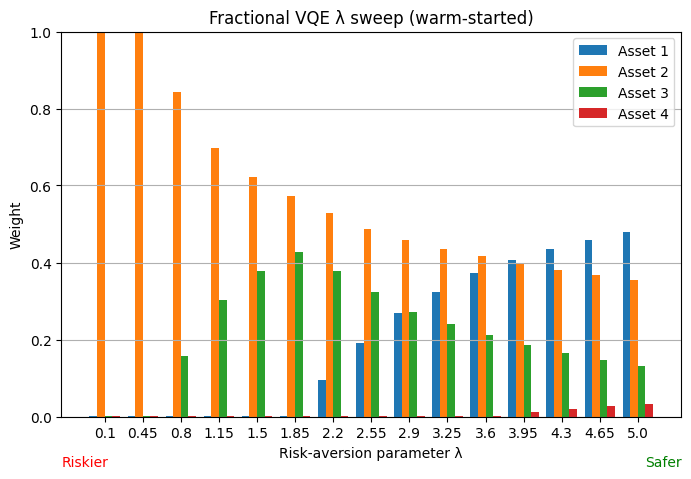

In [12]:
# Allocation sweep plot
x = np.arange(len(lambdas))
bw = 0.2

plt.figure(figsize=(8, 5))
for i in range(n_assets):
    plt.bar(x + i * bw, allocs[:, i], bw, label=f"Asset {i+1}")

plt.xticks(x + bw * (n_assets - 1) / 2, [f"{l}" for l in lambdas])
plt.ylim(0, 1)
plt.xlabel("Risk-aversion parameter λ")
plt.ylabel("Weight")
plt.title("Fractional VQE λ sweep (warm-started)")
plt.legend()
plt.grid(axis="y")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(xmin, ymin - 0.1, "Riskier", ha="left", va="top", fontsize=10, color="red")
plt.text(xmax, ymin - 0.1, "Safer", ha="right", va="top", fontsize=10, color="green")

plt.savefig("images/Fractional_VQE_Lambda_Sweep.png", dpi=200, bbox_inches="tight")
plt.show()

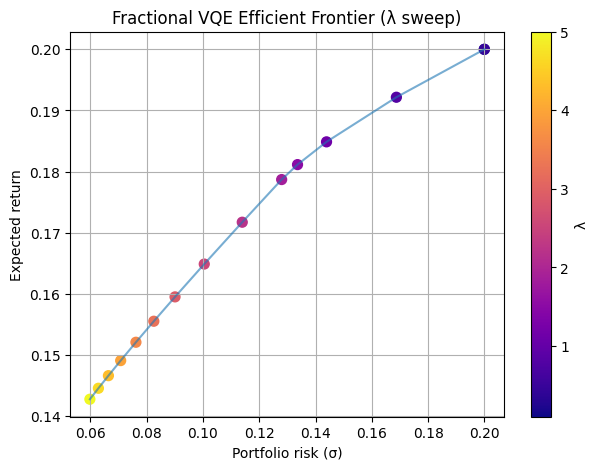

In [13]:
# Efficient frontier for Fractional VQE (λ sweep)
returns_vqe = np.array([portfolio_return(w) for w in allocs], dtype=float)
risks_vqe = np.array([np.sqrt(portfolio_variance(w)) for w in allocs], dtype=float)

order = np.argsort(risks_vqe)
risks_vqe = risks_vqe[order]
returns_vqe = returns_vqe[order]
lambdas_sorted = lambdas[order]

plt.figure(figsize=(7, 5))
sc = plt.scatter(risks_vqe, returns_vqe, c=lambdas_sorted, cmap="plasma", s=50)
plt.plot(risks_vqe, returns_vqe, alpha=0.6)
cbar = plt.colorbar(sc)
cbar.set_label("λ")
plt.xlabel("Portfolio risk (σ)")
plt.ylabel("Expected return")
plt.title("Fractional VQE Efficient Frontier (λ sweep)")
plt.grid(True)
plt.savefig("images/Fractional_VQE_Efficient_Frontier.png", dpi=200, bbox_inches="tight")
plt.show()